Effective energies for these intervals will be set to 0.
Effective energies for these intervals will be set to 0.


C:\Users\siril\AppData\Local\Temp\ipykernel_10264\3206929326.py:479: RankWarning: Polyfit may be poorly conditioned
  plotDispersion(momenta, vals)


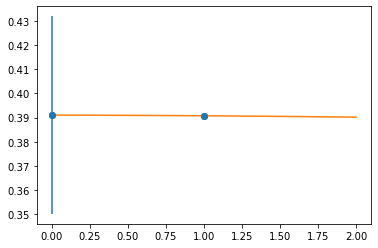

            2
-0.0001453 x - 0.0001453 x + 0.391


In [55]:
from astropy.io import ascii
from astropy import table
from astropy.table import Table
from astropy.table import Column
import numpy as np
import matplotlib.pyplot as plt
import os

# Purpose:    extract file names containing keyword strings from a directory
# Parameters: list of keyword strings KEYWORDS
#             optional directory path string PATH (must end in a "/")
#             if no PATH given, searches the current directory
# Returns:    list of file name strings matching keywords in directory
def searchDir(keywords, path=None):
    if path:
        all_files = [(path + k) for k in os.listdir(path)]
        
    else:
        all_files = os.listdir()
        
    subset = [k for k in all_files if any(keyword in k for keyword in keywords)]
    return subset

# Purpose:    read list of input files to single data table
# Parameters: list of file names to read FILE_LIST;
#             list of table column name strings NAMES;
#             string name of selected column SELECTED
# Returns:    NumPy table of input data
#             Columns represent input files
#             Rows represent time slices
def mergeTables(file_list, names, selected):
    merged = []
    
    # Add selected columns from each file to a single table 
    for i in range(len(file_list)):
        current_file = ascii.read(file_list[i])
        current_table = Table(data=current_file, names=names)
        trial_data = Column(data=current_table[selected], name=str(i)).data
        merged.append(trial_data)

    merged_array = np.asarray(merged)
    final_array = np.transpose(merged_array)
    return final_array

# Purpose:    calculate table of jacknife bins for input data
# Parameters: NumPy table DATA:
#             Columns represent trials
#             Rows represent time slices
# Returns:    NumPy table
#             Columns represent jacknife bins
#             Rows represent time slices
def jacknifeAverage(data):
    binned = np.zeros(data.shape)
    num_slices, num_bins = data.shape
    
    for i in range(num_slices):
        row_sum = np.sum(data[i])
        
        for j in range(num_bins):
            binned[i][j] = row_sum - data[i][j]
      
    binned /= (num_bins - 1)
    return binned

# Purpose:    calculate effective energy from 2-point function values
# Parameters: NumPy table BINS:
#             Columns represent jacknife bin values of 2-point function
#             Rows represent time slices
# Returns:    NumPy table
#             Columns represent jacknife bin values for effective energy
#             Rows represent time slices
def effectiveEnergy(bins):
    num_intervals = bins.shape[0] - 1
    num_bins = bins.shape[1]
    in_by_bin = np.transpose(bins)
    out_by_bin = np.zeros((num_bins, num_intervals))
    
    if (np.any(in_by_bin <= 0)):
        print("Warning: binned data includes negative or zero values.")
        print("Effective energies for these intervals will be set to 0.")
    
    for bin_no in range(num_bins):
        
        for int_no in range(num_intervals):
            if (in_by_bin[bin_no][int_no] <= 0) or (in_by_bin[bin_no][int_no+1] <= 0):
                out_by_bin[bin_no][int_no] = 0
            else:
                out_by_bin[bin_no][int_no] = np.log(in_by_bin[bin_no][int_no] / in_by_bin[bin_no][int_no+1])
    
    final_bins = np.transpose(out_by_bin)
    return final_bins

# Purpose:    average values over table columns
# Parameters: NumPy table VALS:
#             Columns of values to be averaged
#             Rows represent time slices
# Returns:    1D NumPy array
#             Lists mean values of each input row
def averageColumns(vals):
    num_intervals, num_trials = vals.shape
    avg = np.sum(vals, axis=1)
    avg /= num_trials
    
    return avg

# Purpose:    calculate jacknife error across all bins for each timeslice
# Parameters: NumPy table BINNED_DATA:
#             rows representing timeslices,
#             columns representing bins
# Returns:    NumPy 1D array:
#             one error value per timeslice
def jacknifeError2D(binned_data, rho=None):
    num_slices, num_bins = binned_data.shape
    m_factor = (num_bins - 1) / num_bins
    delta_rho = np.zeros(num_slices)
    if rho:
        rho_bars = rho
    else:
        rho_bars = averageColumns(binned_data)
    
    for slice_no in range(num_slices):
        rho_bar = rho_bars[slice_no]
        sigma = 0
        
        for bin_no in range(num_bins):
            diff = binned_data[slice_no][bin_no] - rho_bar
            sigma += np.square(diff)
            
        delta_rho[slice_no] = np.sqrt(sigma * m_factor)

    return delta_rho

# Purpose:    identify the first timeslice whose error exceeds a given threshold
# Parameters: 1D Numpy array of error values JACKNIFE_ERR
#             number MAX_FACT, product with the error of index 1 of JACKNIFE_ERR will set the threshold
# Returns:    index of first value in JACKNIFE_ERR greater than the threshold, or 5, whichever is larger
def maxSlice(jacknife_err, max_fact):
    starting_length = len(jacknife_err)
    err_threshold = jacknife_err[1] * max_fact
    
    for i in range(1, starting_length):
        if jacknife_err[i] > err_threshold:
            break
    
    if i < 5:
        i = 5
        
    return i

# Purpose:    graph effective energy values with jacknife error for each bin
# Parameters: 2D NumPy array EFF_ENERGIES:
#             rows represent timeslices,
#             columns represent bins;
#             1D NumPy array JACK_ERROR:
#             represents error values associated with each bin value
#             number ERR_CUTOFF representing max error as a factor of the error of JACK_ERROR[1]
#             list of integers SELECTED_BINS, if not None then only graph listed indeces
# Returns:    void
def jacknifeGraph(eff_energies, jack_error, err_cutoff=None, selected_bins=None):
    energies_by_bin = np.transpose(eff_energies)  
    num_bins, num_intervals = energies_by_bin.shape
    min_slice = 1
    if err_cutoff:
        max_slice = maxSlice(jack_error, err_cutoff)
    else:
        max_slice = num_intervals
    
    x = range(min_slice, max_slice)
    jack_error = jack_error[min_slice:max_slice]
    
    if selected_bins:
        to_plot = selected_bins
    else:
        to_plot = list(range(num_bins))
    
    for bin_no in to_plot:
        y = energies_by_bin[bin_no][min_slice:max_slice]
        plt.scatter(x, y)
        plt.errorbar(x, y, yerr=jack_error, fmt="o")
        plt.show()
        
    return

# Purpose:    identify the start indexes of plateaus of a given length, excluding index 0
# Parameters: 1D NumPy array representing the bin values for each timeslice YCOORDS
#             1D NumPy array representing jacknife errors for each timeslice YERR
#             optional number LENGTH representing minimum length of the plateau
# Returns:    start index of the plateau, 0 if no plateau is found
def minSlice(ycoords, yerr, length=3):
    num_coords = len(ycoords)
    i = 1
    count = 0
    max_err = 0
    min_err = 0
    
    while i < num_coords:
        if count == length:
            return i - count
        
        else:
            
            if (max_err - min_err) > 0:
                curr_max = ycoords[i] + yerr[i]
                curr_min = ycoords[i] - yerr[i]
                if max_err > curr_max:
                    max_err = curr_max
                if min_err < curr_min:
                    min_err = curr_min
                i += 1
                count += 1
                
            else:
                i -= count
                i += 1
                curr_max = ycoords[i] + yerr[i]
                curr_min = ycoords[i] - yerr[i]
                max_err = curr_max
                min_err = curr_min
                count = 0
            
    return 0

# Purpose:    wrapper function to run multiple bins of data through minSlice()
# Parameters: 2D NumPy array of timeslice rows & bin columns BINNED_VALS
#             1D NumPy array representing jacknife errors for each timeslice BINNED_ERR
#             optional number LENGTH representing minimum length of the plateau
#             optional list of bin indexes SELECTED_BINS to test, if None then test all
# Returns:    1D NumPy array of the plateau start index for each selected bin
def listPlateaus(binned_vals, binned_err, length=3, selected_bins=None):
    vals_by_bin = np.transpose(binned_vals)
    if selected_bins:
        to_plot = selected_bins
    else:
        to_plot = range(len(vals_by_bin))
    plateaus = np.zeros(len(to_plot))
    
    for bin_no in to_plot:
        plateaus[bin_no] = minSlice(vals_by_bin[bin_no], binned_err, length=length)
        
    return plateaus

# Purpose:    calculate one jacknife error value
# Parameters: 1D NumPy array RHOS representing bin values
#             optional number AVG to replace the average of the given bin values
# Returns:    number representing the jacknife error of RHOS
def jacknifeError1D(rhos, avg=None):
    if avg:
        rho_bar = avg
    else:
        rho_bar = np.mean(rhos)
        
    m_fact = (len(rhos) - 1) / len(rhos)
    sig_fact = np.sum( np.square(rhos - rho_bar) )
    delta_t = np.sqrt(m_fact * sig_fact)
    
    return delta_t

# Purpose:    calculate plateau fit value for one data bin
# Parameters: 1D NumPy array YCOORDS representing bin values for each timeslice
#             1D NumPy array YERR representing jacknife error values for each timeslice
#             number MIN_SLICE representing the start slice of the plateau fit
#             number MAX_SLICE representing the end slice of the plateau fit
# Returns:    plateau fit value over the given slices;
#             -1 if the selected data contains junk values
def getPlateauFit(ycoords, yerr, min_slice, max_slice):
    if np.any(ycoords[min_slice:max_slice] <= 0) or np.any(yerr[min_slice:max_slice] <= 0):
        return -1
    
    num = np.sum(ycoords[min_slice:max_slice] * np.power(yerr[min_slice:max_slice], -2))
    den = np.sum(np.power(yerr[min_slice:max_slice], -2))
    if (num == 0) or (den == 0):
        return -1
    
    quo = num/den
    return quo

# Purpose:    calculate & display bin values, jacknife errors, and plateau fit
# Parameters: 1D NumPy array YCOORDS representing bin values for each timeslice
#             1D NumPy array YERR representing jacknife error values for each timeslice
#             number MIN_SLICE representing the start slice of the plateau fit
#             number MAX_SLICE representing the end slice of the plateau fit & plot
#             optional number DELTA to manually set the error bars
# Returns:    tuple representing the plateau fit value (index 0) and error (index 1);
#             None if getPlateauFit() call fails
def plotPlateauFit(ycoords, yerr, min_slice, max_slice, delta=None, show=False):
    plat_fit = getPlateauFit(ycoords, yerr, min_slice, max_slice)
    if plat_fit < 0:
        return None
    
    if delta:
        plat_err = delta
    else:
        plat_err = jacknifeError1D(ycoords[min_slice:max_slice], avg=plat_fit)
    
    if show:
        title_fit = str(round(plat_fit, 5))
        title_err = str(round(plat_err, 5))
        plot_title = "Plateau fit value "+title_fit+" ± "+title_err
        plot_label = "Fit for slices "+str(min_slice)+" to "+str(max_slice)
        x = range(1, len(ycoords))
        y = ycoords[1:]
        e = yerr[1:]
        ax = plt.gca()
        ax.set_xlim([0, max_slice])
        point_range = np.abs(plat_fit - y[1])
        ymin = plat_fit - (point_range * 2)
        ymax = plat_fit + (point_range * 2)
        ax.set_ylim(ymin, ymax)
    
        plt.title(plot_title)
        plt.xlabel(plot_label)
        plt.scatter(x, y)
        plt.errorbar(x, y, yerr=e, fmt="o")
        plt.axvline(x=min_slice, linestyle="dashed")
        plt.axhline(y=plat_fit, linestyle="solid")
        plt.axhline(y=plat_fit-plat_err, linestyle=":")
        plt.axhline(y=plat_fit+plat_err, linestyle=":")
        plt.show()
    
    return [plat_fit, plat_err]

# Purpose:    calculate & display plateau fit starting points whose averages fall within the jacknife margin of error
# Parameters: 1D NumPy array COORDS representing bin values for each timeslice
#             1D NumPy array ERR representing jacknife error values for each timeslice
#             number VARIED_BOUIND representing the boundary point whose alternatives will be calculated
#             number STATIC_BOUND representing the boundary point (min or max slice) that will be held constant
#             optional number FRAC_DELTA representing the minimum error window as a percentage of the average value
# Returns:    the maximum or minimum boundary point (time slice index) whose average falls within the margin of error
def altFits1D(coords, err, static_bound, varied_bound, frac_delta=None, show=False):
    if varied_bound <= static_bound:
        rho_bar = getPlateauFit(coords, err, varied_bound, static_bound)
        
        if rho_bar <= 0:
            print("Plateau fit from slices",varied_bound,"to",static_bound,"was not calculated due to junk values")
            return -1
        
        delta_e = jacknifeError1D(coords[varied_bound:static_bound], avg=rho_bar)
        if delta_e <= 0:
            print("Plateau fit from slices",varied_bound,"to",static_bound,"was not calculated due to junk values")
            return -1
        
        plotPlateauFit(coords, err, varied_bound, static_bound, show=show)
        bound = delta_e
        if frac_delta:
            if (delta_e/rho_bar < frac_delta):
                bound = rho_bar * frac_delta
        
        while varied_bound > 0:
            next_slice = varied_bound - 1
            include_next_plateau = getPlateauFit(coords, err, next_slice, static_bound)
            if include_next_plateau <= 0:
                print("Plateau fit from slices",varied_bound,"to",static_bound,"was not calculated due to junk values")
                return -1

            if (rho_bar-bound) <= include_next_plateau <= (rho_bar+bound):
                varied_bound = next_slice
                rho_bar = getPlateauFit(coords, err, static_bound, varied_bound)
                plotPlateauFit(coords, err, varied_bound, static_bound, delta=bound, show=show)
                
            else:
                return [rho_bar, bound]
                
    else:
        rho_bar = getPlateauFit(coords, err, static_bound, varied_bound)
        
        if rho_bar <= 0:
            print("Plateau fit from slices",static_bound,"to",varied_bound,"was not calculated due to junk values")
            return -1
        
        delta_e = jacknifeError1D(coords[varied_bound:static_bound], avg=rho_bar)
        
        if delta_e <= 0:
            print("Plateau fit from slices",varied_bound,"to",static_bound,"was not calculated due to junk values")
            return -1
        
        plotPlateauFit(coords, err, static_bound, varied_bound, show=show)        
        if (delta_e/rho_bar < frac_delta):
            bound = rho_bar * frac_delta
        else:
            bound = delta_e
        
        while varied_bound < len(coords):
            next_slice = varied_bound + 1
            include_next_plateau = getPlateauFit(coords, err, static_bound, next_slice)
            
            if include_next_plateau <= 0:
                print("Plateau fit from slices",static_bound,"to",varied_bound,"was not calculated due to junk values")
                return -1
            
            if (rho_bar-bound) <= include_next_plateau <= (rho_bar+bound):
                varied_bound = next_slice
                rho_bar = getPlateauFit(coords, err, static_bound, varied_bound)
                plotPlateauFit(coords, err, static_bound, varied_bound, delta=bound, show=show)
                
            else:
                return [rho_bar, bound]
            
# Purpose:    wrapper function to call altFits1D() on multiple data bins
# Parameters: 2D NumPy array BINNED where rows represent timeslices & columns represent bins
#             1D NumPy array ERR representing jacknife error values for each timeslice
#             optional list of bin indexes SELECTED_BINS to test, if None then test all
#             optional integer LENGTH representing minimum length of the plateau
#             optional number MAX_FACT representing the maximum error to plot as a multiple of the first slice's error
#             optional boolean parameter INIT_PLATEAU, if true display plateau fit from index returned by minSlice()
#             optional boolean parameters VARY_MIN, if true then vary the minimum slice index
#             optional boolean parameters VARY_MAX, if true then vary the maximum slice index
#             optional number DELTA_FACT representing the minimum error window as a percentage of the average value
# Returns:    dictionary storing results of altFits1D() for the selected bins:
#             key "plateau" for minimum bound of plateau;
#             key "min" for minimum bound when minimum slice is adjusted down within margin of error;
#             key "max" for maximum bound when maximum slice is adjusted up within margin of error
def altFits2D(binned, err, show=False, mode=0, selected_bins=None, length=3, max_fact=10, delta_fact=None):
    sort_by_bin = np.transpose(binned)
    
    if selected_bins:
        to_plot = selected_bins
    else:
        to_plot = range(len(sort_by_bin))
    fit_vals = []
         
    for bin_no in to_plot:
        if show: print("Bin no.", bin_no)
        bin_data = sort_by_bin[bin_no]
        plateau_min = minSlice(bin_data, err, length=length)
        plateau_max = maxSlice(err, max_fact=max_fact)
        
        if mode == 0:
            fit_vals.append(plotPlateauFit(bin_data, err, plateau_min, plateau_max)[0])
        if mode == 1:
            fit_vals.append(altFits1D(bin_data, err, plateau_max, plateau_min, delta_fact, show=show)[0])
        if mode == 2:
            fit_vals.append(altFits1D(bin_data, err, plateau_min, plateau_max, delta_fact, show=show)[0])
      
    return fit_vals

# Purpose: list ground state value & error from a raw data table
def getGroundState(data, mode=0):
    twoptf = jacknifeAverage(data)
    energy = effectiveEnergy(twoptf)
    err = jacknifeError2D(energy)
    vals = altFits2D(energy, err, mode=mode, delta_fact=None)
    avg = np.mean(vals)
    dev = jacknifeError1D(vals, avg=avg)
    return (avg, dev)

# Purpose: collate average & error values across momenta
def listGroundStates(data_tables, selected_col, mode=0):
    momentum_points = np.zeros((2,len(data_tables)))
    for i in range(len(data_tables)):
        data = mergeTables(data_tables[i], col_names, selected_col)
        momentum_points[0][i], momentum_points[1][i] = getGroundState(data, mode=mode)    
    
    return momentum_points

def plotDispersion(momenta, vals_by_param):
    plot_title = "Energy vs. momentum"
    x = momenta
    y = vals_by_param[0]
    e = vals_by_param[1]
    
    fit = np.polyfit(x, y, 2)
    fit_func = np.poly1d(fit)
    polyline = np.linspace(0, len(momenta), 100)
    plt.scatter(x, y)
    plt.errorbar(x, y, yerr=e, fmt="o")
    plt.plot(polyline, fit_func(polyline)) 
    
    plt.show() 
    print(str(fit_func))
    return

In [ ]:
def main():
    col_names = ['t', 'px', 'py', 'pz', 'C_real']
    data_files_1 = searchDir(["2pt_0"],path="./2pt_data/")
    data_files_2 = searchDir(["2pt_1"],path="./2pt_data/")
    data_tables = [data_files_1, data_files_2]
    selected_col = 'C_real'
    vals = listGroundStates(data_tables, selected_col)
    momenta = np.array([0,1])
    plotDispersion(momenta, vals)